In [1]:
import numpy as np
import pandas as pd
import utils
from scipy import signal 
from matplotlib import pyplot as plt
from preprocess_data import preprocess_data

In [2]:
#preprocess data
preprocess_data("data/karlebach/Accelerometer.csv", "data/karlebach/Gyroscope.csv")

In [8]:
#load preprocessed data for calibration
cal_acc = np.load("preprocessed_data/gebaeude64_cali_acc.npy")
acc = np.load("preprocessed_data/karlebach_acc_all.npy")
print(acc.shape)

#compute sample frequency
recording_time = 305 #taken from meta data
samples = acc.shape[1]
f = samples/recording_time
print("Freq: " +  str(f))
#take the first 10 seconds of the accelerometer
acc = acc[:, :int(f *10)]
print(acc.shape)

(4, 125795)
Freq: 412.44262295081967
(4, 4124)


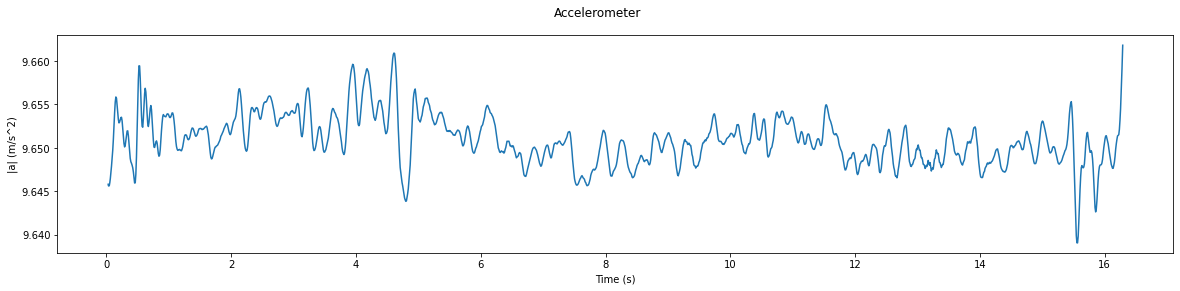

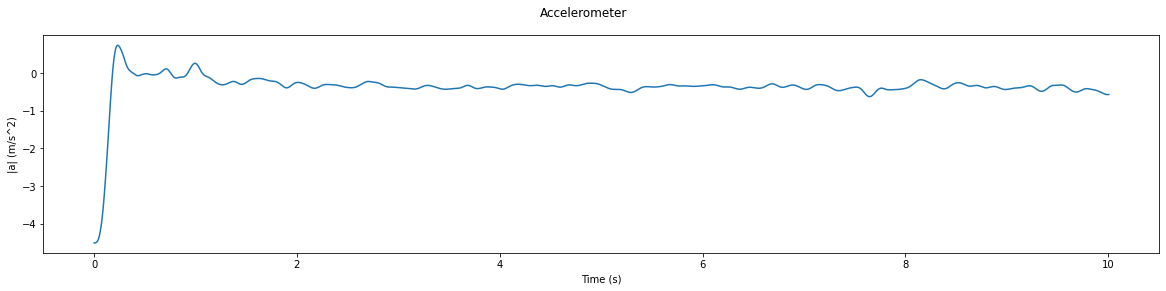

In [302]:
utils.plot_acc(cal_acc, "norm")
utils.plot_acc(acc, "norm")

In [9]:
#estiate g'b(0) by averaging over first ten seconds of accelerometer data
print(acc.shape)
grav = np.mean(acc, axis = 1)

gb_0 = grav[1:]
gb_0

(4, 4124)


array([0.80019899, 6.55358606, 7.35229171])

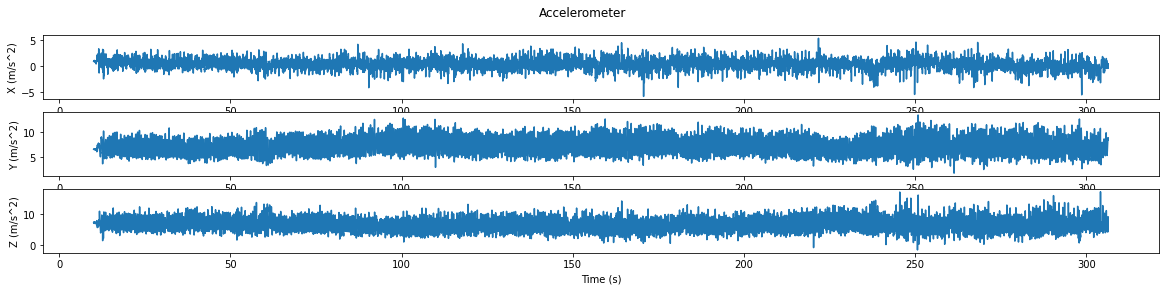

(4, 121671)

In [11]:
acc = np.load("preprocessed_data/karlebach_acc_all.npy")
acc = acc[:,int(f*10):]
utils.plot_acc(acc, "all")
acc.shape


In [12]:
#get g for entire time series
g_list = [gb_0]
sigma = 0.7
for t in range(1, acc.shape[1]):
    g_t = utils.get_gb(acc, t, sigma, g_list[-1])
    g_list.append(g_t)

g_array = np.asarray(g_list)
g_array.shape


(121671, 3)

In [13]:
# compute base shift matrix for entire series
R_list = []
for g in g_array:
    R_list.append(utils.get_matrix(g))

R_array = np.asarray(R_list)
R_array.shape

(121671, 3, 3)

In [14]:
# load gyro data 
gyro = np.load("preprocessed_data/karlebach_gyro_all.npy")
gyro = gyro[1:, int(f*10):].T
gyro.shape

(121671, 3)

In [15]:
# calcuate all turn rates
turn_rate_list = []
for t in range(gyro.shape[0]):
    turn_rate_list.append(R_array[t].T @ gyro[t])

turn_rate_array = np.asarray(turn_rate_list)
turn_rate_array.shape

(121671, 3)

In [20]:
# get turn angles
 

turn_angles = []

for t in range(turn_rate_array.shape[0]):
    turn_angles.append(turn_rate_array[:t].sum(axis = 0))



In [43]:
#because the previous step is computationally quite expensive, an extra cell to avoid recomputing the angles
delta_t = 0.012 #rougly 1/f = 0.0024; constant needs tweaking, as such not computed
turn_angle_array = np.asarray(turn_angles) * delta_t
turn_angle_array.shape

(121671, 3)

In [37]:
# get peaks from accelerometer

acc = np.load("preprocessed_data/karlebach_acc_norm.npy")

acc = acc[:, int(f*10):]

# find peaks
peaks, _ = signal.find_peaks(acc[1], height=12, distance = 50)


In [44]:
step_size = 70

x = np.array([0])
y = np.array([0])

for peak in peaks:
    x = np.append(x, x[-1] + step_size * np.cos(turn_angle_array[peak]))
    y = np.append(y, y[-1] + step_size * np.sin(turn_angle_array[peak]))



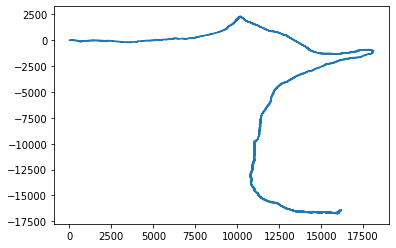

In [45]:
plt.plot(x,y)
plt.show()

array([0.03194309, 0.0295146 , 0.02744966, ..., 0.04342893, 0.0459457 ,
       0.0473342 ])